In [1]:
import warnings
import sys
import os
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.ticker import FuncFormatter
from pathlib import Path 
from tqdm import tqdm
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from autorank import autorank, plot_stats, create_report

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(bias_score_key, target_names_w))

In [4]:
df_meta = pd.read_csv("artifact/metadataset.csv")

# exclude random states because they do not carry information
df_meta = df_meta.drop('dataset_random_state', axis=1)
df_meta = df_meta.drop('sensitive_random_state', axis=1)
df_meta = df_meta.drop('landmarking_random_state', axis=1)

# exclude arrays of class- or group-specific information as their shape is 
#  dataset-specific and does not generalize
df_meta = df_meta.drop('class_weight', axis=1)
df_meta = df_meta.drop('sensitive_group_scores', axis=1)

features = df_meta.columns[:-6]
targets = bias_score_key
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']
target_to_color = dict(zip(targets, COLORS))

In [5]:
cv_result_path="experiment_result/Q1_binary.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)
cv_result_df = cv_result_df[cv_result_df['label'].isin(targets)]

In [26]:
cv_result_df

,Model,Fold,label,balanced,metric,on,value
40,MajorityClass,0,equal_opportunity,False,Accuracy,all,0.710000
41,MajorityClass,0,equal_opportunity,False,F1 Score,all,0.000000
42,MajorityClass,1,equal_opportunity,False,Accuracy,all,0.680000
43,MajorityClass,1,equal_opportunity,False,F1 Score,all,0.000000
44,MajorityClass,2,equal_opportunity,False,Accuracy,all,0.780000
...,...,...,...,...,...,...,...
715,MLP,7,group_fairness,False,F1 Score,all,0.000000
716,MLP,8,group_fairness,False,Accuracy,all,0.580000
717,MLP,8,group_fairness,False,F1 Score,all,0.045455
718,MLP,9,group_fairness,False,Accuracy,all,0.560000


## Experiments

#### Step 1: Normalize targets

In [49]:
X = df_meta[features]
Y = df_meta[targets]

# Normalize Y (each column has 0 mean and 1 standard deviation)
scaler = StandardScaler()
Y_n = scaler.fit_transform(Y)
Y_n = pd.DataFrame(Y_n, columns=Y.columns)

#### Step 2: Binarize

In [50]:
# Targets are normalized with mean 0 and std 1
## We binarize using the sign
Y_bin = (Y_n > 0)

In [84]:
def cross_validate(model, name, target, splits=10, n_sample=1000):
    cv_result=[]
    np.random.seed(2210)
    sample = np.random.choice(list(range(len(X))), n_sample)
    X_sam, Y_bin_sam = X.loc[sample].reset_index(), Y_bin.loc[sample].reset_index()
    kf = KFold(n_splits=splits)
    for index, (train_index, test_index) in enumerate(kf.split(X_sam)):
        
        #Train models and produce predictions based on training and testing split
        model.fit(X_sam.loc[train_index],Y_bin_sam.loc[train_index][target])
        pred=model.predict(X_sam.loc[test_index])
        truth=Y_bin_sam.loc[test_index][target]

        #Calculate the metrics
        acc=accuracy_score(truth,pred)
        f1=f1_score(truth,pred)

        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": False, "metric":'Accuracy', "on":'all', "value":acc})
        cv_result.append({"Model":name, "Fold":index, "label": target, "balanced": False, "metric":'F1 Score', "on":'all', "value":f1})
    
    #Output results as Dataframe
    result_df=pd.DataFrame(cv_result)
    return result_df

In [77]:
# Perform Cross Validation for each model settings 
def evaluate_model(model,name):
    global cv_result_df
    if (len(cv_result_df)>0) and (name in cv_result_df["Model"].unique()):
        print(f"{name} has already been tested")
        return
    for bs in bias_score_key:
        cv_df=cross_validate(model,name,bs)
        cv_result_df=pd.concat([cv_result_df,cv_df],axis=0)
        cv_result_df=cv_result_df.reset_index(drop=True)
        cv_result_df.to_csv(cv_result_path)
        print(f"{bs} completed.")

In [86]:
evaluate_model(DummyClassifier(strategy="most_frequent"),"MajorityClass")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


In [87]:
evaluate_model(LinearSVC(random_state=0, tol=1e-3),"LinearSVM")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


In [88]:
randomforest_parameters={
    "n_estimators":range(25,150,25),
    # "max_depth":[5,10,20,30,40],
    # "max_features":[1,0.5, "sqrt"],
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":800
}
base_model=RandomForestClassifier( n_jobs=2, random_state =800)
gridSearch_model=GridSearchCV(base_model,randomforest_parameters,cv=KFold(**gridSearch_CVsettings),scoring="f1", n_jobs=5)
evaluate_model(gridSearch_model,"RandomForest")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


In [89]:
xgboost_parameters={
    "n_estimators":range(50,300,50),
    # "max_depth":[2,5,10],
    "learning_rate":[0.01,0.1,0.5]
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":600
}
base_model=GradientBoostingClassifier(random_state=600)
gridSearch_model=GridSearchCV(base_model,xgboost_parameters,cv=KFold(**gridSearch_CVsettings),scoring="f1", n_jobs=5)
evaluate_model(gridSearch_model,"XGBoost")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


In [99]:
lightgbm_parameters={
    "n_estimators":range(50,300,50),
    # "max_depth":[2,5,10],#,20,30,40],
    "learning_rate":[0.01,0.1, 0.5],
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":700
}
base_model=LGBMClassifier(objective="binary", n_jobs=5, random_state =700, device_type ="gpu",verbosity=-1)
gridSearch_model=GridSearchCV(base_model,lightgbm_parameters,cv=KFold(**gridSearch_CVsettings),scoring="f1", n_jobs=5)
evaluate_model(gridSearch_model,"LightGBM")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


In [100]:
MLP_parameters={
    # "hidden_layer_sizes":[(50,),(100,),(25,25),(75,25),(25,50,25),(10,30,10)],
    "hidden_layer_sizes":[(25,25),(75,25),(25,50,25),(10,30,10)],
    "learning_rate_init": [0.001,0.01,0.1]
}
gridSearch_CVsettings={
    "n_splits":5,
    "shuffle":True,
    "random_state":900
}
base_model=MLPClassifier(random_state =900,batch_size=20)
gridSearch_model=GridSearchCV(base_model,MLP_parameters,cv=KFold(**gridSearch_CVsettings),scoring="f1", n_jobs=5)
evaluate_model(gridSearch_model,"MLP")

Group Size Disparity completed.
Prevalence Disparity completed.
equal_opportunity completed.
disparate_parity completed.
individual_fairness completed.
group_fairness completed.


## Results

In [6]:
cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)
cv_result_df = cv_result_df[cv_result_df['label'].isin(targets)]

In [7]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [8]:
cv_result_df["Model"].unique()

array(['MajorityClass', 'LinearSVM', 'RandomForest', 'XGBoost',
       'LightGBM', 'MLP'], dtype=object)

In [9]:
#Filtering out NaiveNormal models since their result will further distort the following graph 
model_colors = {'MajorityClass': COLORS[0], 
                'LinearSVM': COLORS[1], 
                'RandomForest': COLORS[5], 
                'XGBoost': COLORS[3],
                'LightGBM': COLORS[4], 
                'MLP': COLORS[6]
               }

#### Overview Summary over all targets

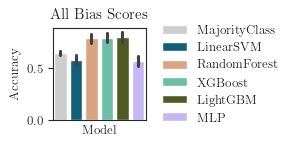

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
sns.barplot(x='Model', y='value', data=cv_result_df[cv_result_df['metric']=='Accuracy'], ax=ax, 
            palette=model_colors, hue='Model', legend='brief')
ax.set_title('All Bias Scores')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

ax.set_xticklabels([]) 
ax.set_xticks([]) 
ax.set_ylabel('Accuracy')

plt.savefig('plots/Q1/overall_comparison_models.pdf', bbox_inches='tight')
plt.show()

#### Model comparison

In [ ]:
def display_full_result(df,metrics,save_path="", figwidth=9):
    df = df[df['metric']==metrics]
    fig, axes = plt.subplots(1, len(df['label'].unique()), figsize=(figwidth,0.8), sharey=False)
    for idx, target in enumerate(df['label'].unique()):
        sns.barplot(data=df[df['label']==target], x='Model', y='value', ax=axes[idx], 
                    palette=model_colors, hue='Model', legend=False if idx!=2 else 'brief')
        axes[idx].set_title(target_names_dict[target])
        # axes[idx].set_xlabel(metrics)
        axes[idx].set_xticks([], [])
        if idx>0: axes[idx].set_ylabel('')
    axes[0].set_ylabel(metrics)
    axes[2].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.15, 1.5), frameon=False)
    # axes[2].legend(ncol=4, loc='upper center', bbox_to_anchor=(1.2, -0.4), frameon=False)
    plt.subplots_adjust(wspace=0.4)
    plt.savefig(f'plots/Q1/comparison_models_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

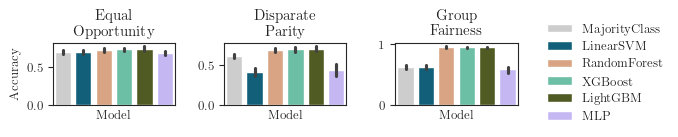

In [41]:
display_full_result(cv_result_df,"Accuracy", figwidth=6)

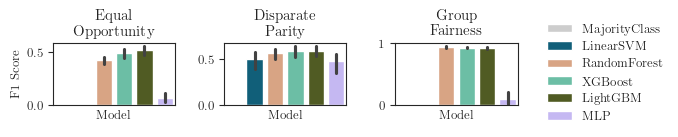

In [43]:
display_full_result(cv_result_df,"F1 Score", figwidth=6)

In [ ]:
def display_individual_axis_result(df,metrics,save_path="", figwidth=9):
    df = df[df['metric']==metrics]
    fig, axes = plt.subplots(1, len(df['label'].unique()), figsize=(figwidth,0.8), sharey=False)
    for idx, target in enumerate(df['label'].unique()):
        sns.boxplot(data=df[df['label']==target], x='Model', y='value', ax=axes[idx], 
                    palette=model_colors, hue='Model', legend=False if idx!=2 else 'brief', linewidth=0.5, fliersize=0.5)
        axes[idx].set_title(target_names_dict[target])
        # axes[idx].set_xlabel(metrics)
        axes[idx].set_xticks([], [])
        if idx>0: axes[idx].set_ylabel('')
    axes[0].set_ylabel(metrics)
    axes[2].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.15, 1.5), frameon=False)
    plt.subplots_adjust(wspace=0.5)
    plt.savefig(f'plots/Q1/comparison_models_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

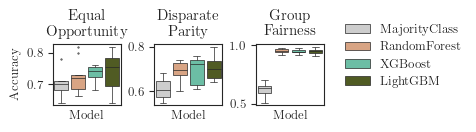

In [24]:
df = cv_result_df[cv_result_df['metric']=='Accuracy']
df_sel = df[df["Model"].isin(["MajorityClass","XGBoost","LightGBM","RandomForest"])]
display_individual_axis_result(df_sel,"Accuracy", figwidth=3.5, save_path='_sel')

In [ ]:
def display_selective_result(df,metrics,save_path="", figwidth=9, figheight=1.4):
    df = df[df['metric']==metrics]
    g = sns.catplot(kind='bar', palette=model_colors, legend='brief', 
                aspect=figwidth/figheight, height=figheight,
                data=df, x='label', y='value', hue='Model')
    new_labels = [target_names_dict[label.get_text()] for label in g.ax.get_xticklabels()]
    g.ax.set_xticklabels(new_labels)
    g.ax.set_xlabel("")
    g.ax.set_ylabel(metrics)
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.9), frameon=False, ncol=1)
    # sns.move_legend(g, "lower center", bbox_to_anchor=(0.44, -0.15), frameon=False, ncol=4)
    g.legend.set_title("")
    plt.savefig(f'Plots/Q1/comparison_models_selective_{metrics}{save_path}.pdf', bbox_inches='tight')
    plt.show()

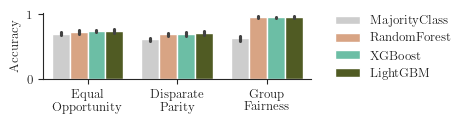

In [56]:
df = cv_result_df[cv_result_df['metric']=='Accuracy']
df_sel = df[df["Model"].isin(["MajorityClass","XGBoost","LightGBM","RandomForest"])]
display_selective_result(df_sel, 'Accuracy', figwidth=3.5)

#### High-level Statistical Summary

In [57]:
df = cv_result_df[cv_result_df['metric']=='Accuracy']
df = df[['Model', 'label', 'value', 'Fold']]
df_piv = df.pivot(index=['Fold','label'], columns='Model', values='value')

In [58]:
result = autorank(df_piv, alpha=0.01)

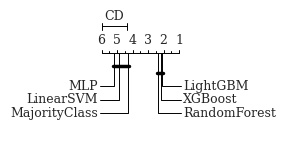

In [ ]:
plt.rc('text', usetex=False)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.6))

plot_stats(result, ax=ax)
plt.savefig('plots/Q1/combined_CD_plot.pdf', bbox_inches='tight')
plt.show()

In [60]:
create_report(result)

The statistical analysis was conducted for 6 populations with 30 paired samples.
The family-wise significance level of the tests is alpha=0.010.
We rejected the null hypothesis that the population is normal for the populations MLP (p=0.001) and LightGBM (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.625 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there